Initial version

In [1]:
!pip install datasets
!pip install transformers
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 97.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.0
    Uninstalling huggingface-hub-0.19.0:
      Successfully uninstalled huggingface-hub-0.19.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 12.5 MB/s eta 0

##Using  neural networks to function approximation




In [156]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [345]:
# Define a simple neural network class
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [353]:
# Define a function to generate both training and test data
def generate_data(function_type,num_samples, test_ratio=0.5):
    # Generate random 1D data
    X = 10* (2 * torch.rand(num_samples, 1) - 1)

    #print(f'Generated data: {X}')

    # Example cubic function for training data
    if function_type == 'cubic':
        Y = 2 * X**3 + 3 * X**2 + 1
    elif function_type == 'sin':
        Y = torch.sin(X)
    elif function_type == 'exp_sin':
        Y = torch.exp(torch.sin(X))
    elif function_type == 'abs':
        Y = torch.abs(X)
    else:
        raise ValueError(f'Invalid function_type: {function_type}')
    # Split the data into training and test sets
    num_test_samples = int(num_samples * test_ratio)
    test_indices = torch.randperm(num_samples)[:num_test_samples]

    test_X = X[test_indices]
    test_Y = Y[test_indices]

    train_X = torch.cat((X[:test_indices[0]], X[test_indices[-1]+1:]))
    train_Y = torch.cat((Y[:test_indices[0]], Y[test_indices[-1]+1:]))

    return (train_X, train_Y), (test_X, test_Y)

# Function to generate 2D data for different functions
def generate_data_2d(function_type, num_samples, test_ratio=0.5):
    # Generate random 2D data
    X = 10*(2 * torch.rand(num_samples, 2)) - 1

    if function_type == 'cubic':
        Y = 2 * X[:, 0]**3 + 3 * X[:, 1]**2 + 1
    elif function_type == 'sin':
        Y = torch.sin(X[:, 0] + X[:, 1])
    elif function_type == 'exp_sin':
        Y = torch.exp(torch.sin(X[:, 0]) + torch.sin(X[:, 1]))
    elif function_type == 'abs':
        Y = torch.abs(X[:, 0]) + torch.abs(X[:, 1])
    else:
        raise ValueError(f'Invalid function_type: {function_type}')

    # Split the data into training and test sets
    num_test_samples = int(num_samples * test_ratio)
    test_indices = torch.randperm(num_samples)[:num_test_samples]

    test_X = X[test_indices]
    test_Y = Y[test_indices]

    train_X = torch.cat((X[:test_indices[0]], X[test_indices[-1]+1:]))
    train_Y = torch.cat((Y[:test_indices[0]], Y[test_indices[-1]+1:]))



    return (train_X, train_Y), (test_X, test_Y)

In [361]:
def train_model(function_type,input_size,hidden_size1,hidden_size2):
  # Instantiate the model, loss function, and optimizer
  output_size = 1
  num_samples=100

  model = SimpleNN(input_size, hidden_size1, hidden_size2, output_size)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.01)

  # Lists to store training and test losses for plotting
  train_losses = []
  test_losses = []

  # Training loop
  epochs = 100
  # Generate data
  if(input_size==1):
    (train_inputs, train_targets), (test_inputs, test_targets) = generate_data(function_type,num_samples)
  elif(input_size==2):
    (train_inputs, train_targets), (test_inputs, test_targets) = generate_data_2d(function_type,num_samples)
  for epoch in range(epochs):

      # Forward pass for training data
      outputs = model(train_inputs)

      # Compute the training loss
      if(input_size==1):
        loss = criterion(outputs, train_targets)
      elif(input_size==2):
        loss = criterion(outputs, train_targets.unsqueeze(1))

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      # Print and plot the loss every 100 epochs
      if epoch % 2 == 0:
          #print(f'Epoch {epoch}/{epochs}, Train Loss: {loss.item()}')

          # Store training loss for plotting
          train_losses.append(loss.item())

          # Forward pass for test data
          with torch.no_grad():
              model.eval()
              test_outputs = model(test_inputs)
              model.train()

          # Compute the test loss
          if(input_size==1):
            test_loss = criterion(test_outputs, test_targets)
          elif(input_size==2):
            test_loss = criterion(test_outputs, test_targets.unsqueeze(1))
          # Store test loss for plotting
          test_losses.append(test_loss.item())

          #print(f'Test Loss: {test_loss.item()}')

          num_examples=5
          random_indices = torch.randint(0, 20, (num_examples ,)) #test ratio = 0.2

          print(epoch)
          for i in random_indices:
            print(f'Target: {test_targets[i].item()}, Model output: {test_outputs[i].item()}')

          print("-----------------------------------------------------------------------------------")


  # Plotting the training and test losses with a continuous line
  plt.figure(figsize=(10, 5))
  plt.plot(range(0, epochs, 2), train_losses, label='Training Loss')
  plt.plot(range(0, epochs, 2), test_losses, label='Test Loss')
  plt.title('Training and Test Losses')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()








## Function approximation 1D

0
Target: 623.6063842773438, Model output: -0.03026547282934189
Target: -472.30328369140625, Model output: -0.24629440903663635
Target: 811.8336791992188, Model output: -0.03495045751333237
Target: 439.4171142578125, Model output: -0.024654529988765717
Target: 181.3989715576172, Model output: -0.013750978745520115
-----------------------------------------------------------------------------------
2
Target: 181.3989715576172, Model output: 0.19807571172714233
Target: 1.6660314798355103, Model output: 0.06168650463223457
Target: 181.3989715576172, Model output: 0.19807571172714233
Target: -955.151123046875, Model output: -1.4058961868286133
Target: 21.85006332397461, Model output: 0.12090562283992767
-----------------------------------------------------------------------------------
4
Target: 11.322349548339844, Model output: 0.1471754014492035
Target: -955.151123046875, Model output: -2.4149436950683594
Target: -955.151123046875, Model output: -2.4149436950683594
Target: -472.3032836914

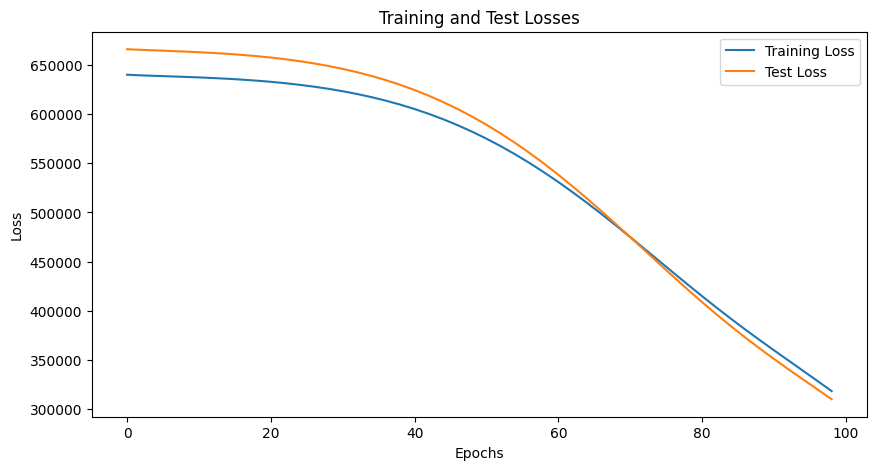

In [362]:
#cubic function
train_model('cubic',input_size=1,hidden_size1=12,hidden_size2=12)

0
Target: -0.2883836627006531, Model output: -0.176552414894104
Target: -0.8934328556060791, Model output: 0.2894786298274994
Target: 0.9330601692199707, Model output: 0.3693851828575134
Target: 0.4402163624763489, Model output: 0.20259369909763336
Target: 0.013302084989845753, Model output: 0.2596833407878876
-----------------------------------------------------------------------------------
2
Target: 0.14000147581100464, Model output: 0.05678301304578781
Target: -0.3410869836807251, Model output: 0.05498180538415909
Target: 0.8716439008712769, Model output: 0.18530237674713135
Target: 0.5381833910942078, Model output: 0.16263052821159363
Target: 0.04245751351118088, Model output: 0.04452630132436752
-----------------------------------------------------------------------------------
4
Target: 0.9330601692199707, Model output: -0.029087692499160767
Target: 0.013302084989845753, Model output: 0.06949583441019058
Target: 0.13006095588207245, Model output: 0.12526798248291016
Target: 0.93

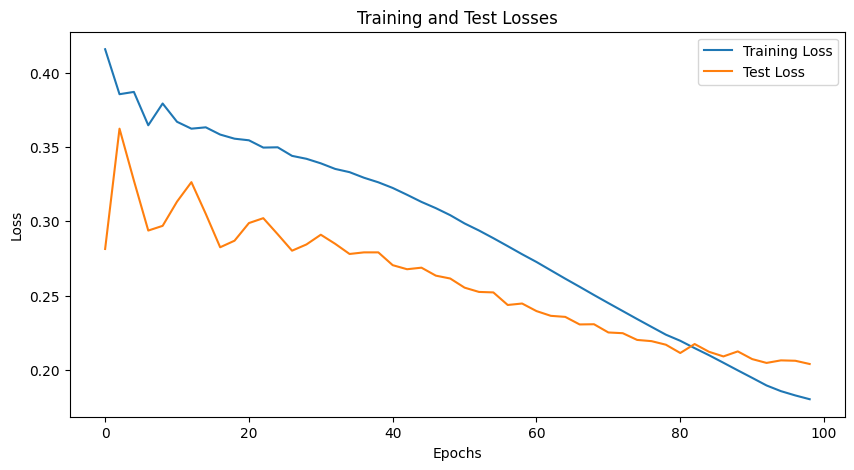

In [363]:
#sin function
train_model('sin',input_size=1,hidden_size1=12,hidden_size2=12)


0
Target: 2.482919692993164, Model output: -0.5633199214935303
Target: 2.581958055496216, Model output: 0.12693604826927185
Target: 0.7179715037345886, Model output: 0.2267225831747055
Target: 0.48582759499549866, Model output: 0.19588622450828552
Target: 1.084428071975708, Model output: -0.9922003746032715
-----------------------------------------------------------------------------------
2
Target: 0.4849216341972351, Model output: -0.08725899457931519
Target: 1.9463454484939575, Model output: -0.3027898967266083
Target: 0.3688731789588928, Model output: -0.034395456314086914
Target: 0.7264556884765625, Model output: -0.12007933855056763
Target: 2.1523966789245605, Model output: 0.2721921503543854
-----------------------------------------------------------------------------------
4
Target: 0.40544310212135315, Model output: 0.032211512327194214
Target: 0.48582759499549866, Model output: 0.338979572057724
Target: 2.581958055496216, Model output: 0.3223464787006378
Target: 2.58195805549

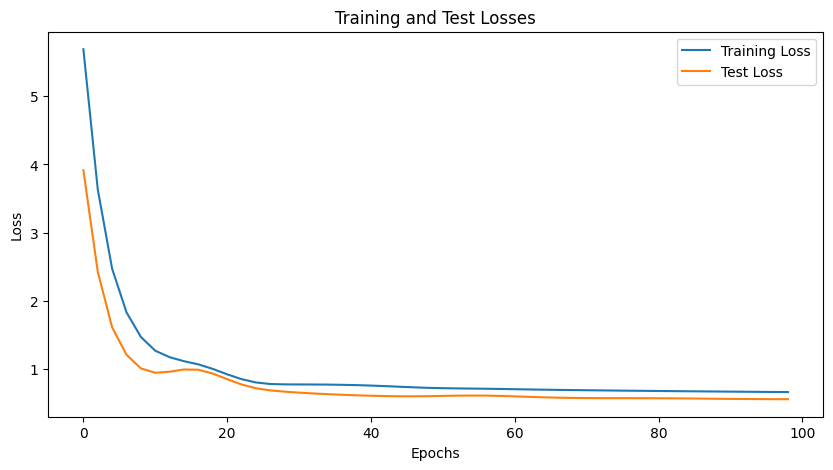

In [364]:
#exponential function
train_model('exp_sin',input_size=1,hidden_size1=12,hidden_size2=12)


0
Target: 2.2165822982788086, Model output: 0.24049517512321472
Target: 9.108457565307617, Model output: -2.531609535217285
Target: 2.2165822982788086, Model output: 0.24049517512321472
Target: 8.063636779785156, Model output: -2.2108113765716553
Target: 0.38287878036499023, Model output: 0.1857500523328781
-----------------------------------------------------------------------------------
2
Target: 8.56805419921875, Model output: -0.9046643972396851
Target: 3.814399242401123, Model output: -0.23107033967971802
Target: 1.1427593231201172, Model output: 0.13313430547714233
Target: 8.063636779785156, Model output: -0.8331882953643799
Target: 0.38287878036499023, Model output: 0.2581774592399597
-----------------------------------------------------------------------------------
4
Target: 8.499847412109375, Model output: 0.6426011919975281
Target: 8.063636779785156, Model output: -0.09843388199806213
Target: 9.108457565307617, Model output: -0.1703314483165741
Target: 7.051797866821289, Mo

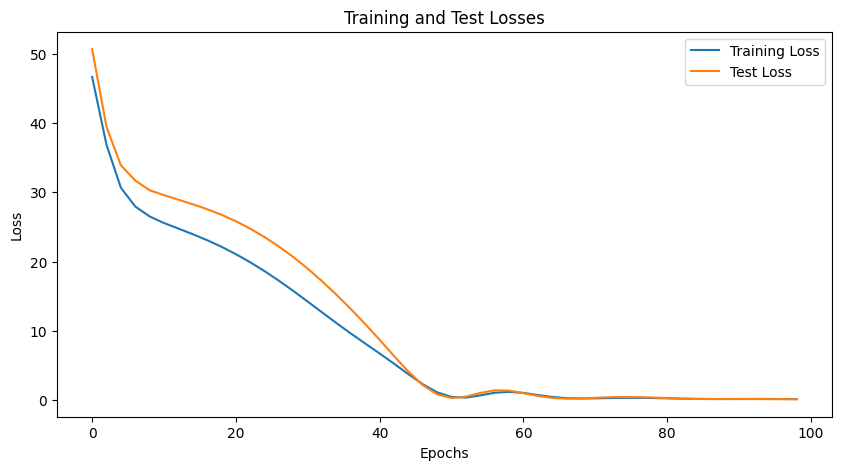

In [365]:
#absolute function
train_model('abs',input_size=1,hidden_size1=12,hidden_size2=12)

## Function approximation 2D


0
Target: 12788.853515625, Model output: 4.240243911743164
Target: 3377.03076171875, Model output: 2.6856963634490967
Target: 387.5124206542969, Model output: 1.556091547012329
Target: 10409.001953125, Model output: 3.896562099456787
Target: 10409.001953125, Model output: 3.896562099456787
-----------------------------------------------------------------------------------
2
Target: 8108.5546875, Model output: 5.716063022613525
Target: 387.5124206542969, Model output: 2.356123924255371
Target: 8108.5546875, Model output: 5.716063022613525
Target: 387.5124206542969, Model output: 2.356123924255371
Target: 8108.5546875, Model output: 5.716063022613525
-----------------------------------------------------------------------------------
4
Target: 501.31878662109375, Model output: 4.133254528045654
Target: 3089.6005859375, Model output: 5.888655662536621
Target: 700.3840942382812, Model output: 5.141457557678223
Target: 6679.22802734375, Model output: 7.491787910461426
Target: 3179.0241699218

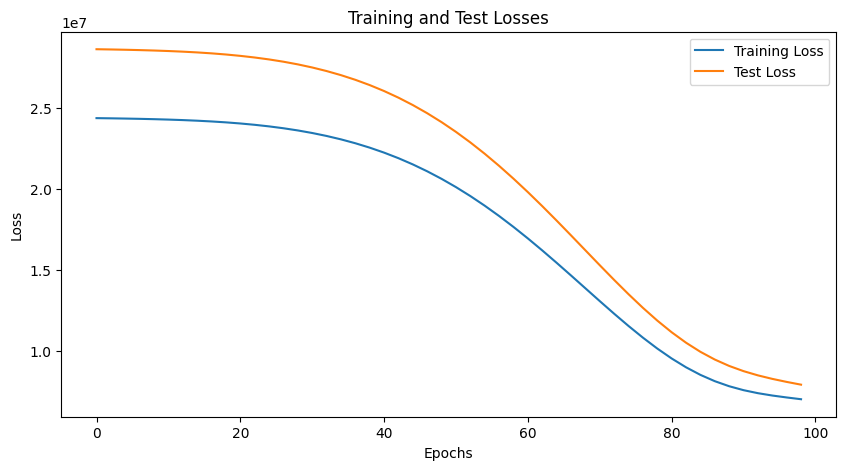

In [366]:
#cubic function
train_model('cubic',input_size=2,hidden_size1=12,hidden_size2=12)

0
Target: 0.29033592343330383, Model output: 0.753150463104248
Target: -0.7158554196357727, Model output: 0.6588894128799438
Target: 0.9860816597938538, Model output: 0.7800427079200745
Target: -0.7104437947273254, Model output: 0.7108765840530396
Target: -0.6165728569030762, Model output: 0.9841985702514648
-----------------------------------------------------------------------------------
2
Target: -0.10961771756410599, Model output: 0.41669753193855286
Target: -0.5241362452507019, Model output: 0.6338134407997131
Target: -0.39256274700164795, Model output: 0.3550553321838379
Target: -0.6165728569030762, Model output: 0.19213521480560303
Target: -0.9986704587936401, Model output: 0.2876523733139038
-----------------------------------------------------------------------------------
4
Target: -0.7158554196357727, Model output: -0.6663066148757935
Target: -0.6165728569030762, Model output: -0.4979974031448364
Target: 0.9860816597938538, Model output: 0.04531185328960419
Target: -0.58766

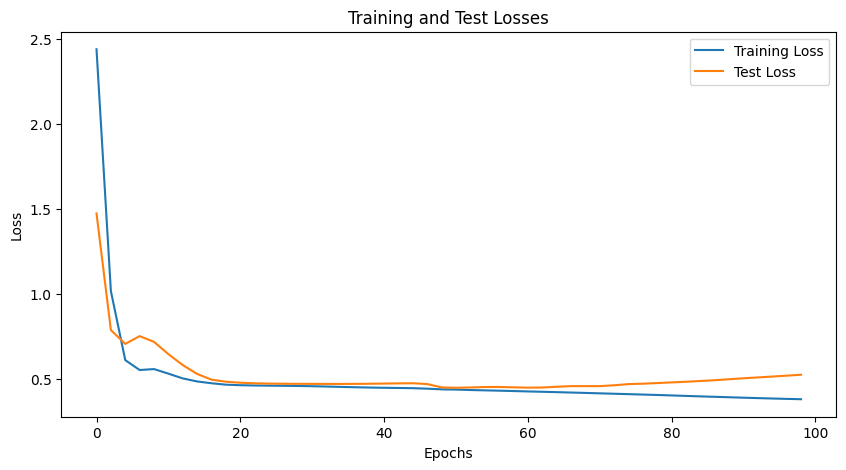

In [367]:
#sin function
train_model('sin',input_size=2,hidden_size1=12,hidden_size2=12)

0
Target: 2.492133378982544, Model output: -0.07218319177627563
Target: 0.6020222902297974, Model output: 0.009101063013076782
Target: 0.48367682099342346, Model output: 1.160325050354004
Target: 4.361441612243652, Model output: 0.11994346976280212
Target: 0.6020222902297974, Model output: 0.009101063013076782
-----------------------------------------------------------------------------------
2
Target: 4.7946391105651855, Model output: 1.1166256666183472
Target: 0.8314128518104553, Model output: 0.8408247828483582
Target: 0.21323151886463165, Model output: 0.6548676490783691
Target: 1.295880675315857, Model output: 0.9811012744903564
Target: 1.295880675315857, Model output: 0.9811012744903564
-----------------------------------------------------------------------------------
4
Target: 2.619804859161377, Model output: 2.2881364822387695
Target: 0.21323151886463165, Model output: 0.9908484220504761
Target: 0.2035617232322693, Model output: 2.923471212387085
Target: 2.492133378982544, Mod

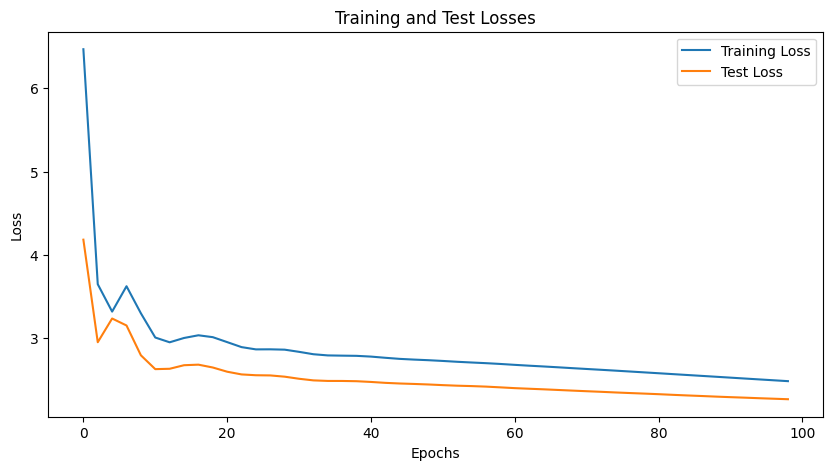

In [368]:
#exponential function
train_model('exp_sin',input_size=2,hidden_size1=12,hidden_size2=12)

0
Target: 24.006793975830078, Model output: 1.778942584991455
Target: 31.701492309570312, Model output: 2.183946132659912
Target: 12.723814964294434, Model output: 0.59073805809021
Target: 11.91340160369873, Model output: 0.5513027906417847
Target: 9.79664421081543, Model output: 0.5019776821136475
-----------------------------------------------------------------------------------
2
Target: 12.909893035888672, Model output: 0.9552682638168335
Target: 19.612018585205078, Model output: 2.3117921352386475
Target: 6.6689653396606445, Model output: 1.0631954669952393
Target: 19.612018585205078, Model output: 2.3117921352386475
Target: 31.701492309570312, Model output: 4.024618625640869
-----------------------------------------------------------------------------------
4
Target: 24.006793975830078, Model output: 5.200015544891357
Target: 12.723814964294434, Model output: 1.9761078357696533
Target: 23.526901245117188, Model output: 3.6337902545928955
Target: 27.386333465576172, Model output: 

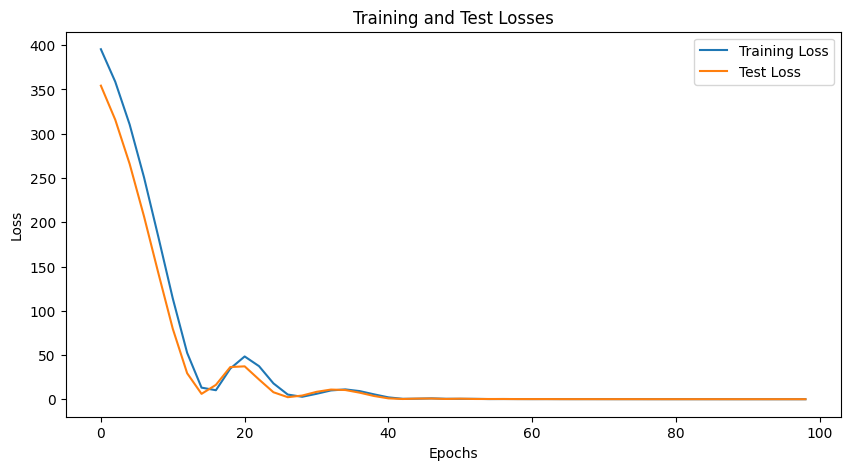

In [369]:
#absolute function
train_model('abs',input_size=2,hidden_size1=12,hidden_size2=12)